<a href="https://colab.research.google.com/github/dasha-shchep/fssh_colab/blob/master/fssh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing the FSSH algorithm on Tully's example problems
This notebook will go through the basic FSSH algorithm and run parallel trajectories as described in the original paper - Tully, J.C. *J. Chem. Phys.* (1990) **93** 1061.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# !pip install pyscf
# from pyscf import scf

The three types of model potential that Tully described are:

A. Simple avoided crossing (SAX)

B. Dual avoided crossing (DAX)

C. Extended coupling with reflection (ECR)

On the next line we create a SAX potential:

In [0]:
# Setting up model (1-D potential) classes
# Creating a model class lets us play with more complex model potentials later
class SAXModel:
  """
  First model two-level problem defined by the following interactions in the
  diabatic representstion:
  V11(X) = A[1 - exp(-BX)] for x > 0
  V11(X) = - A[1 - exp(BX)] for x < 0
  V22(X) = - V11(X)
  V21(X) = V12(X) = C exp(-DX**2)
  Default choice of parameters:
  A = 0.01 ; B = 1.6 ; C = 0.005 ; D = 1.0
  """
  _num_states = 2
  _num_dims   = 1
  
  def __init__(self,a=0.01,b=1.6,c=0.005,d=1.0):
    self.A = a
    self.B = b
    self.C = c
    self.D = d

  def V(self,R):
    sign = np.sign(R)
    V11 = sign*self.A*(1 - np.exp(-sign*self.B*R))
    V22 = -V11
    V12 = self.C*np.exp(-self.D*R**2)
    V21 = V12
    return np.array([[V11,V12],[V21,V22]])

  def dV(self,R):
    dV11 = - self.A*self.B*np.exp(-self.B*abs(R))
    dV22 = -dV11
    dV12 = self.C*np.exp(-self.D*R**2)
    dV21 = dV12
    return np.array([[dV11,dV12],[dV21,dV22]])

  def dD(self,R):
    z = (self.V(R)[0,0] - self.V(R)[1,1])/(self.V(R)[0,1]*2e0)
    D12 = 1e0/(2e0*(1+z**2)) * ( ( 1e0/(2e0*self.V(R)[0,1]**2)) * 
                                    (self.V(R)[0,1]*(self.dV(R)[0,0]-self.dV(R)[1,1]) 
                                    -self.dV(R)[0,1]*(self.V(R)[0,0]-self.V(R)[1,1])))
    D21 = -D12
    D11 = 0
    D22 = 0
    return np.array([[D11,D12],[D21,D22]])


In [22]:
# class DAXModel:
#  def __init__(self):
#    self.representation = representation # Adiabatic or Diabatic

model = SAXModel()
model._num_states
model.B

1.6

Plotting the potentials in the diabatic representation, with nonadiabatic coupling.

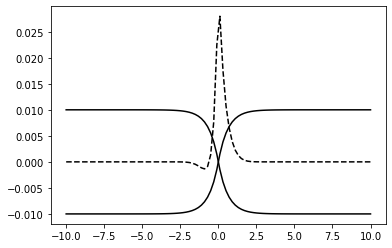

In [25]:
xmin,xmax = -10,10
model.V(xmin)[0,0]
x = np.linspace(xmin,xmax,100)

fig = plt.figure()
plt.plot(x, model.V(x)[1,1], 'k-')
plt.plot(x, model.V(x)[0,0], 'k-');
plt.plot(x, 0.02*model.dD(x)[1,0], 'k--');

In [46]:
R = 0.1
z = (model.V(R)[0,0] - model.V(R)[1,1])/(model.V(R)[0,1]*2e0)
k = 1e0/(2e0*(1+z**2)) * ( ( 1e0/(2e0*model.V(R)[0,1]**2)) * 
                                    ( model.V(R)[0,1]*(model.dV(R)[0,0]-model.dV(R)[1,1]) 
                                    - model.dV(R)[0,1]*(model.V(R)[0,0]-model.V(R)[1,1])))
print(k)

-0.5442423427035081


In [0]:
vect = np.random.rand(1,8)
print(vect)
for i in vect:
  print(model.V(i))


[[0.15861607 0.04308918 0.95873151 0.25977154 0.10535437 0.60495324
  0.70431314 0.80776143]]
[[[ 0.00160104  0.00046292  0.0065167   0.00248549  0.00109427
    0.00485957  0.00539178  0.00588743]
  [ 0.00975155  0.00998145  0.00398851  0.00934745  0.00988962
    0.00693525  0.00608927  0.00520753]]

 [[ 0.00975155  0.00998145  0.00398851  0.00934745  0.00988962
    0.00693525  0.00608927  0.00520753]
  [-0.00160104 -0.00046292 -0.0065167  -0.00248549 -0.00109427
   -0.00485957 -0.00539178 -0.00588743]]]


In [0]:
# Generate initial conditions
numTraj = 100
dT = 1 # timestep
initP = 0
initQ = 1
mass = 2000

In [0]:
# Classical nuclei velocity verlet integrator
acceleration = force / mass
def velocity_verlet(old_position, old_velocity, timestep,acceleration):
  new_position = old_position + old_velocity * timestep
  new_velocity = old_velocity + acceleration * timestep
  return new_position, new_velocity

0.11418160778148789

In [0]:
# Calculate hopping probability & random number generator
def surface_hop():
  random_number = np.random.rand()
  test
  if random_number < test:
    bool = True
  elif random_number > test:
    bool = False
  else:
    print("Error")
  return bool

Trying to run CUDA on Colab GPUs

In [0]:
import torch

In [0]:
torch.cuda.memory_allocated()

0

In [0]:
a = torch.rand(128,600).cuda()

In [0]:
b = np.random.rand(128,600)

In [0]:
def func(obj):
  out = obj**2
  return out

In [0]:
%timeit func(a)

The slowest run took 1600.61 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 10.1 µs per loop


In [0]:
%timeit func(b)

The slowest run took 13.36 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 86.1 µs per loop
